In [1]:
#!pip install transformers datasets

In [1]:
import pandas as pd
import datasets

import torch

In [2]:
train_data = pd.read_csv('./toy_dataset_label.csv',sep='\t',encoding='latin-1')
print(f'coumns:{[x for x in train_data.columns]}')

coumns:['ID', 'FILE', 'AUTHOR', 'BORN-DIED', 'TITLE', 'DATE', 'TECHNIQUE', 'LOCATION', 'FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'URL']


In [3]:
train_data.describe()

,ID
count,43455.000000
mean,21728.000000
std,12544.522311
min,1.000000
25%,10864.500000
50%,21728.000000
75%,32591.500000
max,43455.000000


In [4]:
train_data.head()

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
0,1,1.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Allegory,1598,"Oil on copper, 56 x 47 cm","Alte Pinakothek, Munich",painting,mythological,German,1601-1650,http://www.wga.hu/html/a/aachen/allegory.html
1,2,2.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)","Bacchus, Ceres and Cupid",-,"Oil on canvas, 163 x 113 cm","Kunsthistorisches Museum, Vienna",painting,mythological,German,1601-1650,http://www.wga.hu/html/a/aachen/bacchus.html
2,3,3.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Joking Couple,-,"Copperplate, 25 x 20 cm","Kunsthistorisches Museum, Vienna",painting,genre,German,1601-1650,http://www.wga.hu/html/a/aachen/j_couple.html
3,4,4.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Portrait of Emperor Rudolf II,1590s,"Oil on canvas, 60 x 48 cm","Kunsthistorisches Museum, Vienna",painting,portrait,German,1601-1650,http://www.wga.hu/html/a/aachen/rudolf2.html
4,5,5.jpg,"AACHEN, Hans von","(b. 1552, KÃ¶ln, d. 1615, Praha)",Self-Portrait with a Glass of Wine,c. 1596,"Oil on canvas, 53 x 44 cm",Private collection,painting,portrait,German,1601-1650,http://www.wga.hu/html/a/aachen/selfport.html


In [5]:
features = ['FILE','AUTHOR','TITLE','DATE','TECHNIQUE']

train_data = train_data[features]
train_data = train_data[:500]
train_data.head()

,FILE,AUTHOR,TITLE,DATE,TECHNIQUE
0,1.jpg,"AACHEN, Hans von",Allegory,1598,"Oil on copper, 56 x 47 cm"
1,2.jpg,"AACHEN, Hans von","Bacchus, Ceres and Cupid",-,"Oil on canvas, 163 x 113 cm"
2,3.jpg,"AACHEN, Hans von",Joking Couple,-,"Copperplate, 25 x 20 cm"
3,4.jpg,"AACHEN, Hans von",Portrait of Emperor Rudolf II,1590s,"Oil on canvas, 60 x 48 cm"
4,5.jpg,"AACHEN, Hans von",Self-Portrait with a Glass of Wine,c. 1596,"Oil on canvas, 53 x 44 cm"


In [6]:
from tqdm import tqdm

with tqdm(total=len(train_data)) as pbar:
    for idx in range(train_data.shape[0]):
        pbar.set_description(f'Art Piece N°: {idx}')
        train_data['FILE'][idx] = './toy_dataset/'+str(idx+1)+'.jpg'
        train_data['TECHNIQUE'][idx] = train_data['TECHNIQUE'][idx].split(',')[0].strip()
        pbar.update()


Art Piece N°: 499: 100%|██████████| 500/500 [00:00<00:00, 641.85it/s]


In [7]:
train_data = train_data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE':'title', 'DATE':'date','TECHNIQUE':'technique'})

In [8]:
train_dataset = datasets.Dataset.from_dict(train_data).cast_column('image',datasets.Image())
print(train_dataset)

Dataset({
    features: ['image', 'author', 'title', 'date', 'technique'],
    num_rows: 500
})


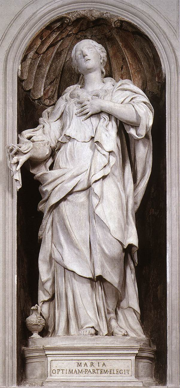

Description: ALGARDI, Alessandro St Mary Magdalene 1629 Stucco


In [9]:
sample = train_dataset[260]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['author'] + ' ' + sample['title'] + ' ' + sample['date'] + ' ' + sample['technique']
print(f'Description: {caption}')

In [10]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor.image_mean, std = processor.image_std)
size = (processor.size['shortest_edge']
        if 'shortest_edge' in processor.size
        else (processor.size['height'],processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [12]:
def transforms(examples):
    examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
    del examples['image']
    return examples

In [13]:
train_dataset = train_dataset.with_transform(transforms)

In [14]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [15]:
import evaluate

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references = labels)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ d:\envs\tf\lib\site-packages\transformers\utils\import_utils.py:1157 in _get_module              │
│                                                                                                  │
│   1154 │                                                                                         │
│   1155 │   def _get_module(self, module_name: str):                                              │
│   1156 │   │   try:                                                                              │
│ ❱ 1157 │   │   │   return importlib.import_module("." + module_name, self.__name__)              │
│   1158 │   │   except Exception as e:                                                            │
│   1159 │   │   │   raise RuntimeError(                                                           │
│   1160 │   │   │   │   f"Failed to import {self.__name__}.{module_name} because of the followin  │
│                                                                                                  │
│ d:\envs\tf\lib\importlib\__init__.py:126 in import_module                                        │
│                                                                                                  │
│   123 │   │   │   if character != '.':                                                           │
│   124 │   │   │   │   break                                                                      │
│   125 │   │   │   level += 1                                                                     │
│ ❱ 126 │   return _bootstrap._gcd_import(name[level:], package, level)                            │
│   127                                                                                            │
│   128                                                                                            │
│   129 _RELOADING = {}                                                                            │
│ <frozen importlib._bootstrap>:1050 in _gcd_import                                                │
│ <frozen importlib._bootstrap>:1027 in _find_and_load                                             │
│ <frozen importlib._bootstrap>:1006 in _find_and_load_unlocked                                    │
│ <frozen importlib._bootstrap>:688 in _load_unlocked                                              │
│ <frozen importlib._bootstrap_external>:883 in exec_module                                        │
│ <frozen importlib._bootstrap>:241 in _call_with_frames_removed                                   │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\pipelines\__init__.py:69 in <module>                   │
│                                                                                                  │
│    66 from .mask_generation import MaskGenerationPipeline                                        │
│    67 from .object_detection import ObjectDetectionPipeline                                      │
│    68 from .question_answering import QuestionAnsweringArgumentHandler, QuestionAnsweringPipel   │
│ ❱  69 from .table_question_answering import TableQuestionAnsweringArgumentHandler, TableQuesti   │
│    70 from .text2text_generation import SummarizationPipeline, Text2TextGenerationPipeline, Tr   │
│    71 from .text_classification import TextClassificationPipeline                                │
│    72 from .text_generation import TextGenerationPipeline                                        │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\pipelines\table_question_answering.py:26 in <module>   │
│                                                                                                  │
│    23                                                      

In [16]:
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\rullo\AppData\Local\Temp\ipykernel_15984\75571910.py:3 in <module>                      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\rullo\\AppData\\Local\\Temp\\ipykernel_15984\\75571910.py'                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'str' object has no attribute 'shape'

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=2)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\rullo\AppData\Local\Temp\ipykernel_15984\993914777.py:3 in <module>                     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\rullo\\AppData\\Local\\Temp\\ipykernel_15984\\993914777.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'shape'

In [19]:
processor.decode(batch['input_ids'][0])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\rullo\AppData\Local\Temp\ipykernel_15984\1466174886.py:1 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\rullo\\AppData\\Local\\Temp\\ipykernel_15984\\1466174886.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ViTImageProcessor' object has no attribute 'decode'

In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels = 4)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
training_args = TrainingArguments(output_dir='./',
                                  remove_unused_columns=False,
                                  evaluation_strategy = 'epoch',
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=16,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10)

trainer = Trainer(model = model,
                  args = training_args,
                  data_collator = data_collator,
                  train_dataset=train_dataset,
                  tokenizer=processor)
trainer.train()

d:\envs\tf\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


  0%|          | 0/16 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\rullo\AppData\Local\Temp\ipykernel_15984\4152831857.py:17 in <module>                   │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\rullo\\AppData\\Local\\Temp\\ipykernel_15984\\4152831857.py'                         │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\trainer.py:1664 in train                               │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\trainer.py:1932 in _inner_training_loop                │
│                                                                                                  │
│   1929 │   │   │   │   │   with model.no_sync():                                                 │
│   1930 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1931 │   │   │   │   else:                                                                     │
│ ❱ 1932 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1933 │   │   │   │                                                                             │
│   1934 │   │   │   │   if (                                                                      │
│   1935 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\trainer.py:2727 in training_step                       │
│                                                                                                  │
│   2724 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2725 │   │                                                                                     │
│   2726 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2727 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2728 │   │                                                                                     │
│   2729 │   │   if self.args.n_gpu > 1:                                                           │
│   2730 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ d:\envs\tf\lib\site-packages\transformers\trainer.py:2772 in compute_loss                        │
│                                                                                                  │
│   2769 │   │   │   │   loss = self.label_smoother(outputs, labels)                               │
│   2770 │   │   else:                                       

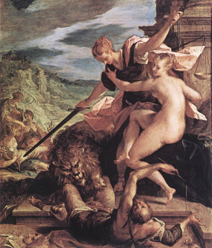

In [ ]:
sample = train_dataset[0]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))

In [ ]:
from transformers import pipeline

classifier = pipeline('image-classification', model=model)
classifier(image)

In [ ]:
inputs = processor(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the painting of the painting shows the painter, who was a young woman, who was the first of the artist, who was the most famous in the artist, and the first of the cr
